In [24]:
import pandas as pd

In [25]:
pd.read_csv("/content/traffic_data_dyn (1).csv")

,Time,Vehicle Count at Junction A,Vehicle Count at Junction B,Vehicle Count at Junction C,Vehicle Count at Junction D,Vehicle Count at Junction E,Avg Speed on AB,Avg Speed on BC,Avg Speed on CA,Avg Speed on CD,Avg Speed on ED,Avg Speed on DA
0,1.0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,2.0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0.0,1.317469
2,3.0,0,0,0,0,0,0.0,2.181660,0.0,0.0,0.0,3.199004
3,4.0,0,0,0,0,0,0.0,4.622117,0.0,0.0,0.0,5.222676
4,5.0,0,0,0,0,0,0.0,6.796626,0.0,0.0,0.0,6.901379
...,...,...,...,...,...,...,...,...,...,...,...,...
86630,86631.0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0.0,13.716305
86631,86632.0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0.0,12.823331
86632,86633.0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0.0,13.493811
86633,86634.0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0.0,13.758053


In [30]:
from huggingface_hub import notebook_login
notebook_login()


Using device: cuda
Dataset loaded with shape: (86635, 12)
Columns: ['Time', 'Vehicle Count at Junction A', 'Vehicle Count at Junction B', 'Vehicle Count at Junction C', 'Vehicle Count at Junction D', 'Vehicle Count at Junction E', 'Avg Speed on AB', 'Avg Speed on BC', 'Avg Speed on CA', 'Avg Speed on CD', 'Avg Speed on ED', 'Avg Speed on DA']

First few rows:
   Time  Vehicle Count at Junction A  Vehicle Count at Junction B  \
0   1.0                            0                            0   
1   2.0                            0                            0   
2   3.0                            0                            0   
3   4.0                            0                            0   
4   5.0                            0                            0   

   Vehicle Count at Junction C  Vehicle Count at Junction D  \
0                            0                            0   
1                            0                            0   
2                            0    

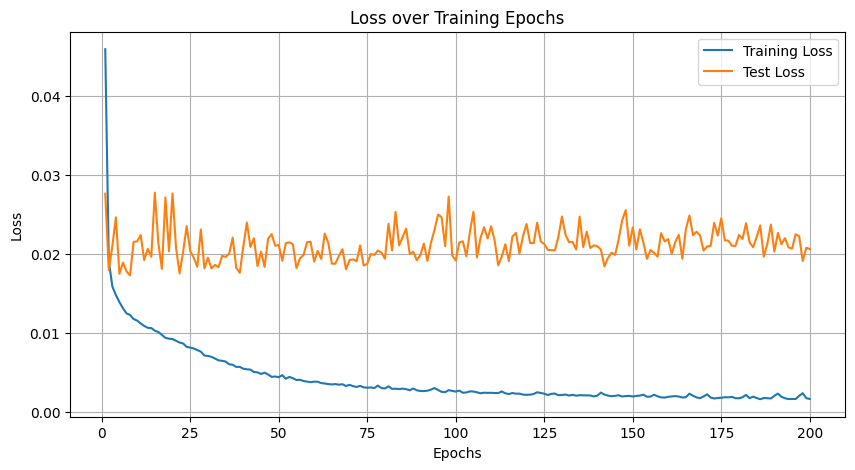


Model Evaluation:
Training RMSE: 0.4289
Training MAE: 0.3347
Test RMSE: 2.0110
Test MAE: 1.5734


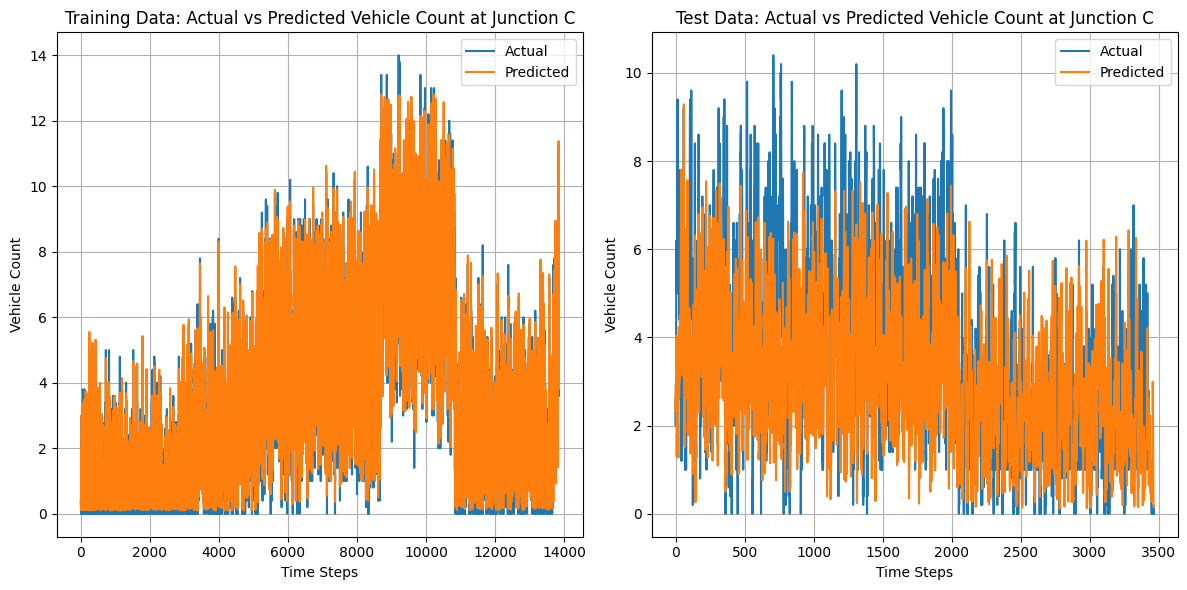

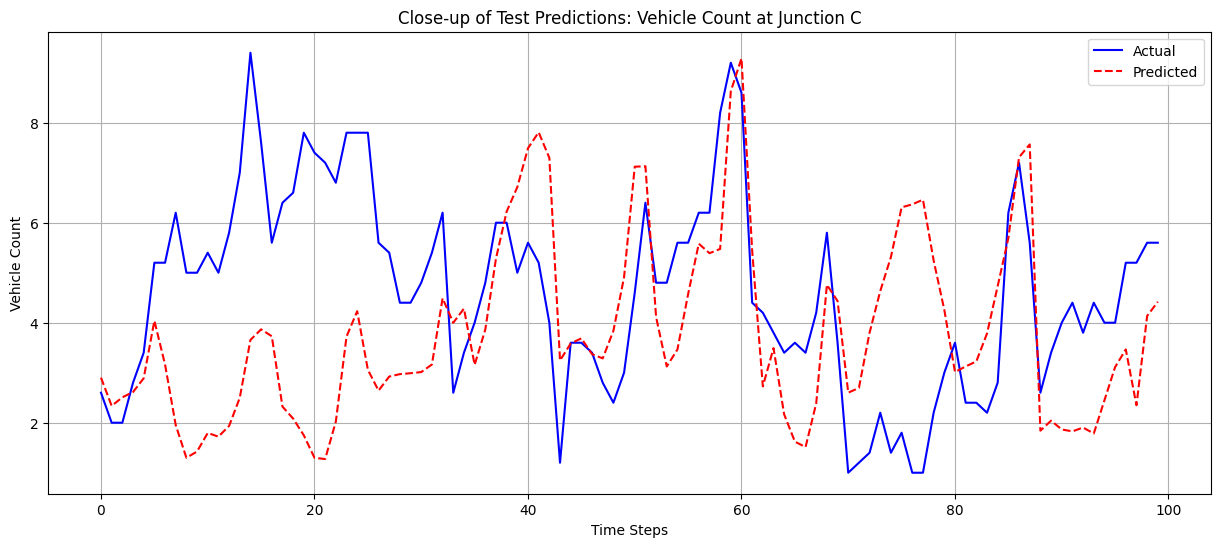

Model saved to 'traffic_transformer_model.pth'


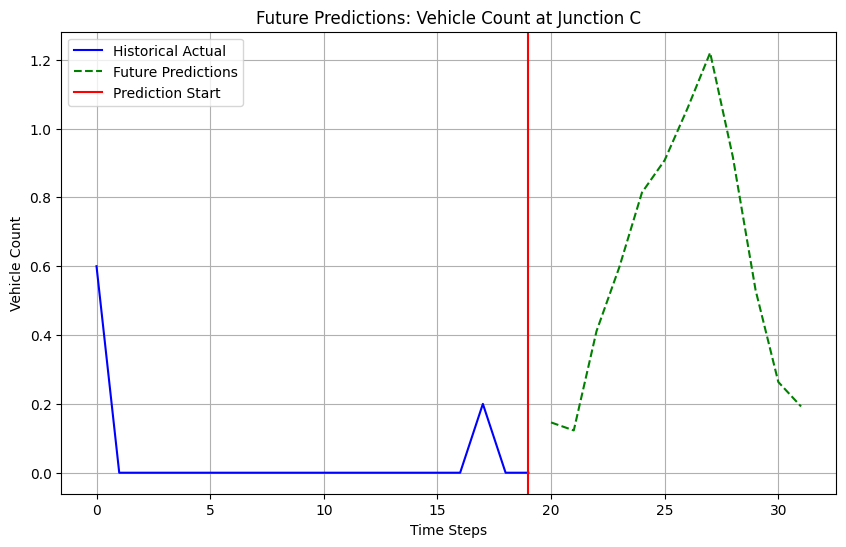


Future predictions for the next hour (12 time steps of 5 minutes each):
Step 1: 0.15 vehicles
Step 2: 0.12 vehicles
Step 3: 0.41 vehicles
Step 4: 0.60 vehicles
Step 5: 0.81 vehicles
Step 6: 0.91 vehicles
Step 7: 1.06 vehicles
Step 8: 1.22 vehicles
Step 9: 0.92 vehicles
Step 10: 0.53 vehicles
Step 11: 0.26 vehicles
Step 12: 0.19 vehicles


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
data = pd.read_csv('/content/traffic_data_dyn (1).csv')
print("Dataset loaded with shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nFirst few rows:")
print(data.head())

# Resample into 5-minute intervals (group by Time rounded to nearest 5)
# Since we're keeping Time as numerical, we'll round to the nearest 5
data['Time_5min'] = np.round(data['Time'] / 5) * 5
resampled_data = data.groupby('Time_5min').mean().reset_index()
print("\nResampled data shape:", resampled_data.shape)
print("\nResampled data first few rows:")
print(resampled_data.head())

# Define features and target
target_col = 'Vehicle Count at Junction C'
feature_cols = [col for col in resampled_data.columns if col != 'Time_5min' and col != target_col]

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(resampled_data[feature_cols])
y = scaler_y.fit_transform(resampled_data[[target_col]])

# Create sequences for the transformer model
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# Sequence length (context window)
seq_length = 12  # 1 hour with 5-minute intervals

# Create sequences
X_seq, y_seq = create_sequences(X, y, seq_length)
print(f"\nSequence shapes - X: {X_seq.shape}, y: {y_seq.shape}")

# Split data into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a custom time series transformer model
class CustomTimeSeriesModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=4, num_heads=4, dropout=0.1):
        super(CustomTimeSeriesModel, self).__init__()

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Input projection
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # Output projection
        self.output_projection = nn.Linear(hidden_dim, 1)  # 1 value to predict

        # Positional encoding
        self.register_buffer(
            "positional_encoding",
            self._generate_positional_encoding(seq_length, hidden_dim)
        )

    def _generate_positional_encoding(self, seq_length, d_model):
        position = torch.arange(seq_length).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))

        pos_encoding = torch.zeros(seq_length, d_model)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)

        return pos_encoding.unsqueeze(0)  # [1, seq_length, d_model]

    def forward(self, x):
        # x shape: [batch_size, seq_length, features]

        # Project input to hidden dimension
        x = self.input_projection(x)  # [batch_size, seq_length, hidden_dim]

        # Add positional encoding
        x = x + self.positional_encoding

        # Apply transformer encoder
        x = self.transformer_encoder(x)  # [batch_size, seq_length, hidden_dim]

        # Get the last time step
        x = x[:, -1, :]  # [batch_size, hidden_dim]

        # Project to output
        output = self.output_projection(x)  # [batch_size, 1]

        return output

# Initialize the model
input_dim = X_train.shape[2]  # Number of features
hidden_dim = 64
num_layers = 4
num_heads = 4
dropout = 0.1

model = CustomTimeSeriesModel(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    dropout=dropout
).to(device)

print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters")

# Define optimizer and loss function
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Prepare for training
num_epochs = 200
train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)

        # Calculate loss
        loss = criterion(predictions, batch_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_X.size(0)

    # Calculate average training loss for the epoch
    train_loss = train_loss / len(train_dataset)
    train_losses.append(train_loss)

    # Evaluate the model
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            # Forward pass
            predictions = model(batch_X)

            # Calculate loss
            loss = criterion(predictions, batch_y)
            test_loss += loss.item() * batch_X.size(0)

    # Calculate average test loss for the epoch
    test_loss = test_loss / len(test_dataset)
    test_losses.append(test_loss)

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plot training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Training Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

# Make predictions
model.eval()
with torch.no_grad():
    # Training data predictions
    train_preds = model(X_train_tensor).cpu().numpy()

    # Test data predictions
    test_preds = model(X_test_tensor).cpu().numpy()

# Inverse transform predictions
train_preds = scaler_y.inverse_transform(train_preds)
test_preds = scaler_y.inverse_transform(test_preds)
y_train_orig = scaler_y.inverse_transform(y_train)
y_test_orig = scaler_y.inverse_transform(y_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_orig, train_preds))
train_mae = mean_absolute_error(y_train_orig, train_preds)
test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_preds))
test_mae = mean_absolute_error(y_test_orig, test_preds)

print("\nModel Evaluation:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Plot actual vs predicted values for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(y_train_orig, label='Actual')
plt.plot(train_preds, label='Predicted')
plt.title('Training Data: Actual vs Predicted Vehicle Count at Junction C')
plt.xlabel('Time Steps')
plt.ylabel('Vehicle Count')
plt.legend()
plt.grid(True)

# Plot actual vs predicted values for test data
plt.subplot(1, 2, 2)
plt.plot(y_test_orig, label='Actual')
plt.plot(test_preds, label='Predicted')
plt.title('Test Data: Actual vs Predicted Vehicle Count at Junction C')
plt.xlabel('Time Steps')
plt.ylabel('Vehicle Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('predictions_plot.png')
plt.show()

# Create a more detailed plot for a subset of test data
subset_size = min(100, len(test_preds))
plt.figure(figsize=(15, 6))
plt.plot(range(subset_size), y_test_orig[:subset_size], 'b-', label='Actual')
plt.plot(range(subset_size), test_preds[:subset_size], 'r--', label='Predicted')
plt.title('Close-up of Test Predictions: Vehicle Count at Junction C')
plt.xlabel('Time Steps')
plt.ylabel('Vehicle Count')
plt.legend()
plt.grid(True)
plt.savefig('test_predictions_closeup.png')
plt.show()

# Save the model
torch.save(model.state_dict(), 'traffic_transformer_model.pth')
print("Model saved to 'traffic_transformer_model.pth'")

# Function to make future predictions (next 12 time steps)
def predict_future(model, last_sequence, scaler_y, steps=12):
    model.eval()
    future_preds = []
    current_sequence = last_sequence.clone()

    for _ in range(steps):
        with torch.no_grad():
            # Predict next value
            next_pred = model(current_sequence)
            future_preds.append(next_pred.cpu().numpy())

            # Update sequence for next prediction
            # Remove first time step and add prediction at the end
            new_last_step = torch.zeros_like(current_sequence[:, 0, :])
            # Place the prediction in the position corresponding to the target variable
            target_idx = feature_cols.index(target_col) if target_col in feature_cols else -1
            if target_idx >= 0:
                new_last_step[:, target_idx] = next_pred.squeeze()

            # Update sequence by removing first step and adding new step at the end
            current_sequence = torch.cat([
                current_sequence[:, 1:, :],
                new_last_step.unsqueeze(1)
            ], dim=1)

    # Convert predictions to numpy array and inverse transform
    future_preds = np.array(future_preds).squeeze()
    if future_preds.ndim == 1:
        future_preds = future_preds.reshape(-1, 1)
    future_preds = scaler_y.inverse_transform(future_preds)

    return future_preds.flatten()

# Get the last sequence from the test set and predict future values
last_sequence = X_test_tensor[-1:].clone()
future_predictions = predict_future(model, last_sequence, scaler_y, steps=12)

# Plot future predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_orig[-20:])), y_test_orig[-20:], 'b-', label='Historical Actual')
plt.plot(range(len(y_test_orig[-20:]), len(y_test_orig[-20:]) + len(future_predictions)),
         future_predictions, 'g--', label='Future Predictions')
plt.axvline(x=len(y_test_orig[-20:]) - 1, color='r', linestyle='-', label='Prediction Start')
plt.title('Future Predictions: Vehicle Count at Junction C')
plt.xlabel('Time Steps')
plt.ylabel('Vehicle Count')
plt.legend()
plt.grid(True)
plt.savefig('future_predictions_plot.png')
plt.show()

print("\nFuture predictions for the next hour (12 time steps of 5 minutes each):")
for i, pred in enumerate(future_predictions):
    print(f"Step {i+1}: {pred:.2f} vehicles")

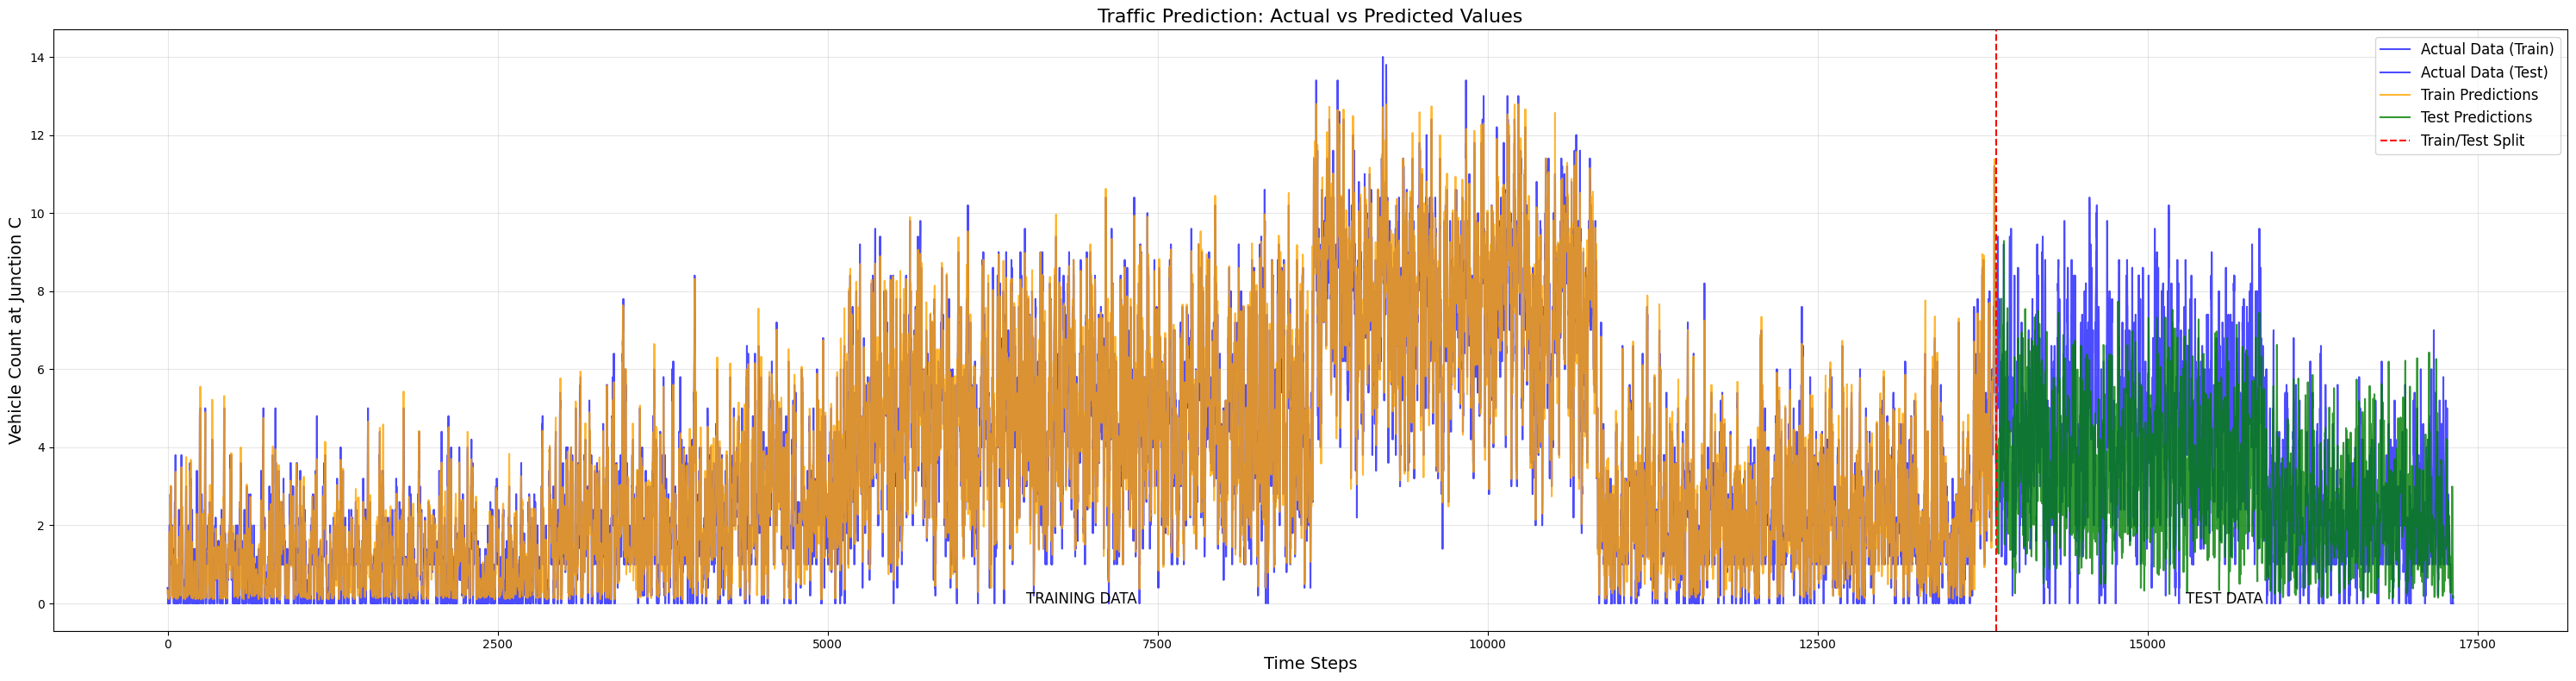

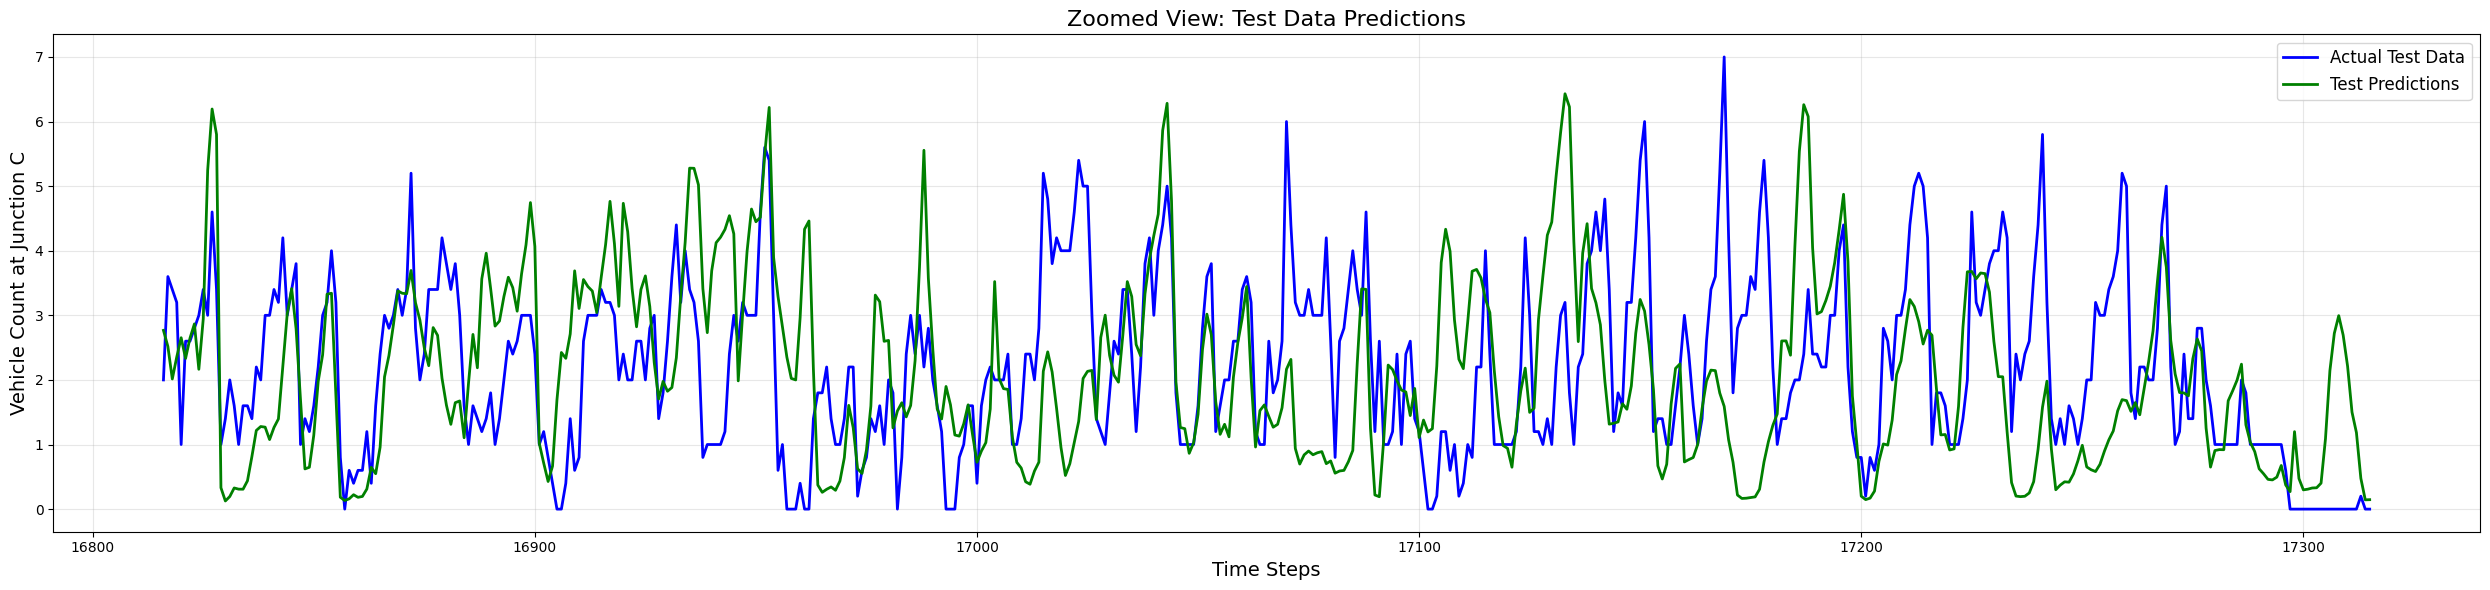

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these variables are already available from the earlier code
# y_train_orig: original training target values
# train_preds: predictions on training data
# y_test_orig: original test target values
# test_preds: predictions on test data

# Create a figure
plt.figure(figsize=(30, 8))

# Define indices for x-axis
train_indices = np.arange(len(y_train_orig))
test_indices = np.arange(len(y_train_orig), len(y_train_orig) + len(y_test_orig))

# Plot actual data (both train and test)
plt.plot(train_indices, y_train_orig, 'b-', label='Actual Data (Train)', alpha=0.7)
plt.plot(test_indices, y_test_orig, 'b-', label='Actual Data (Test)', alpha=0.7)

# Plot training predictions in orange
plt.plot(train_indices, train_preds, 'orange', markersize=4, label='Train Predictions', alpha=0.8)

# Plot test predictions in green
plt.plot(test_indices, test_preds, 'green', markersize=4, label='Test Predictions', alpha=0.8)

# Add a vertical line to separate train and test data
plt.axvline(x=len(y_train_orig), color='red', linestyle='--', label='Train/Test Split')

# Add labels and title
plt.title('Traffic Prediction: Actual vs Predicted Values', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Vehicle Count at Junction C', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)

# Add text annotations for clarity
plt.text(len(train_indices)/2, min(y_train_orig), 'TRAINING DATA', horizontalalignment='center', fontsize=12)
plt.text(len(train_indices) + len(test_indices)/2, min(y_test_orig), 'TEST DATA', horizontalalignment='center', fontsize=12)

# Improve appearance
plt.tight_layout()

# Save the plot
plt.savefig('traffic_prediction_comparison.png', dpi=300)

# Show the plot
plt.show()

# Optional: Create a zoomed-in version of a section of the test data
# for better visibility of prediction accuracy
plt.figure(figsize=(25, 6))

# Select last 100 points from test data (or any other subset you want to focus on)
subset_size = min(500, len(test_preds))
subset_indices = test_indices[-subset_size:]

plt.plot(subset_indices, y_test_orig[-subset_size:], 'b-', label='Actual Test Data', linewidth=2)
plt.plot(subset_indices, test_preds[-subset_size:], 'g-',  markersize=4, label='Test Predictions', linewidth=2)

plt.title('Zoomed View: Test Data Predictions', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Vehicle Count at Junction C', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('zoomed_test_predictions.png', dpi=300)
plt.show()

In [63]:
from graphviz import Digraph

dot = Digraph()

# Define layers
dot.node("Input", "Input (Time-Series Features)")
dot.node("PE", "Positional Encoding")
dot.node("Transformer", "Transformer Encoder (4 Layers, 4 Heads)")
dot.node("Dense", "Fully Connected Layer")
dot.node("Output", "Final Prediction")

# Connect layers
dot.edge("Input", "PE", label="Add Position Encoding")
dot.edge("PE", "Transformer", label="Multi-Head Attention")
dot.edge("Transformer", "Dense", label="Flatten & Project")
dot.edge("Dense", "Output", label="Predict Future Value")

# Save and render
dot.render("transformer_architecture", format="png", view=True)


'transformer_architecture.png'

In [61]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.8 MB/s eta 0:00:00
